In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from chronos import ChronosPipeline
from pytorch_lightning.callbacks import EarlyStopping, Callback, ModelCheckpoint
from ray import tune
from ray.tune import CLIReporter
from ray.tune.integration.pytorch_lightning import TuneReportCallback
from ray.tune.schedulers import ASHAScheduler
from torchmetrics import MeanAbsoluteError, MeanAbsolutePercentageError, MetricCollection
from darts.dataprocessing.transformers import Scaler
from darts import TimeSeries, concatenate
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorboard
import os

In [145]:
df = pd.read_csv('EDvisitfileL.csv', encoding='ISO-8859-1')
total_length = len(df)
train_end =3000

df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df = df.rename(columns={'No_Linkou': 'No'})


#columns = ['No', 'Mon', 'Tue', 'Wed', 'Thr', 'Fri', 'Sat', 'Sun',  'YearScaled',
           #'MonthScaled', 'Dayscaled', 'NewYear', '3Lock', 'ConfirmedCases_scaled', 'Screening']

#df_multivariate = df[columns]

train_df = df.iloc[:train_end]
test_df = df.iloc[train_end:]
df_combined = df[['No']]

In [146]:
pipeline = ChronosPipeline.from_pretrained(
  "amazon/chronos-t5-tiny",
  device_map="cpu",
  torch_dtype=torch.float32,
)

context_array = train_df['No'].to_numpy().astype('float32')  # Convert to numpy and ensure type
context_tensor = torch.tensor(context_array)

In [147]:
prediction_length = 60
extended_train_df = train_df.copy()

# 创建一个空的DataFrame来存储所有的预测结果
all_forecasts = pd.DataFrame()

# 循环，直到测试集被完全覆盖
while not test_df.empty:
    # 更新上下文张量，包含了扩展后的训练集
    context_array = extended_train_df['No'].to_numpy().astype('float32')
    context_tensor = torch.tensor(context_array).unsqueeze(0)  # 添加批次维度

    # 计算这轮预测的长度，不能超过测试集的剩余长度
    current_prediction_length = min(prediction_length, len(test_df))

    # 生成预测
    forecast = pipeline.predict(
        context=context_tensor,
        prediction_length=current_prediction_length,
        num_samples=3,
        temperature=1.0,
        top_k=50,
        top_p=1.0,
    )

    # 假设 forecast 的形状是 (1, 20, current_prediction_length)
    # 计算所有样本的平均预测值
    forecast_mean = forecast.mean(dim=1).squeeze().numpy()

    # 准备这轮预测的日期
    last_date = extended_train_df.index.max()
    forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=current_prediction_length)

    # 将这轮的平均预测值与其日期结合
    forecast_df = pd.DataFrame(data=forecast_mean, index=forecast_dates, columns=['No'])
    all_forecasts = pd.concat([all_forecasts, forecast_df])

    # 将接下来的30天（或剩余的天数）的实际数据从测试集移动到扩展的训练集中
    actual_data_to_add = test_df.iloc[:current_prediction_length]
    extended_train_df = pd.concat([extended_train_df, actual_data_to_add])
    test_df = test_df.iloc[current_prediction_length:]

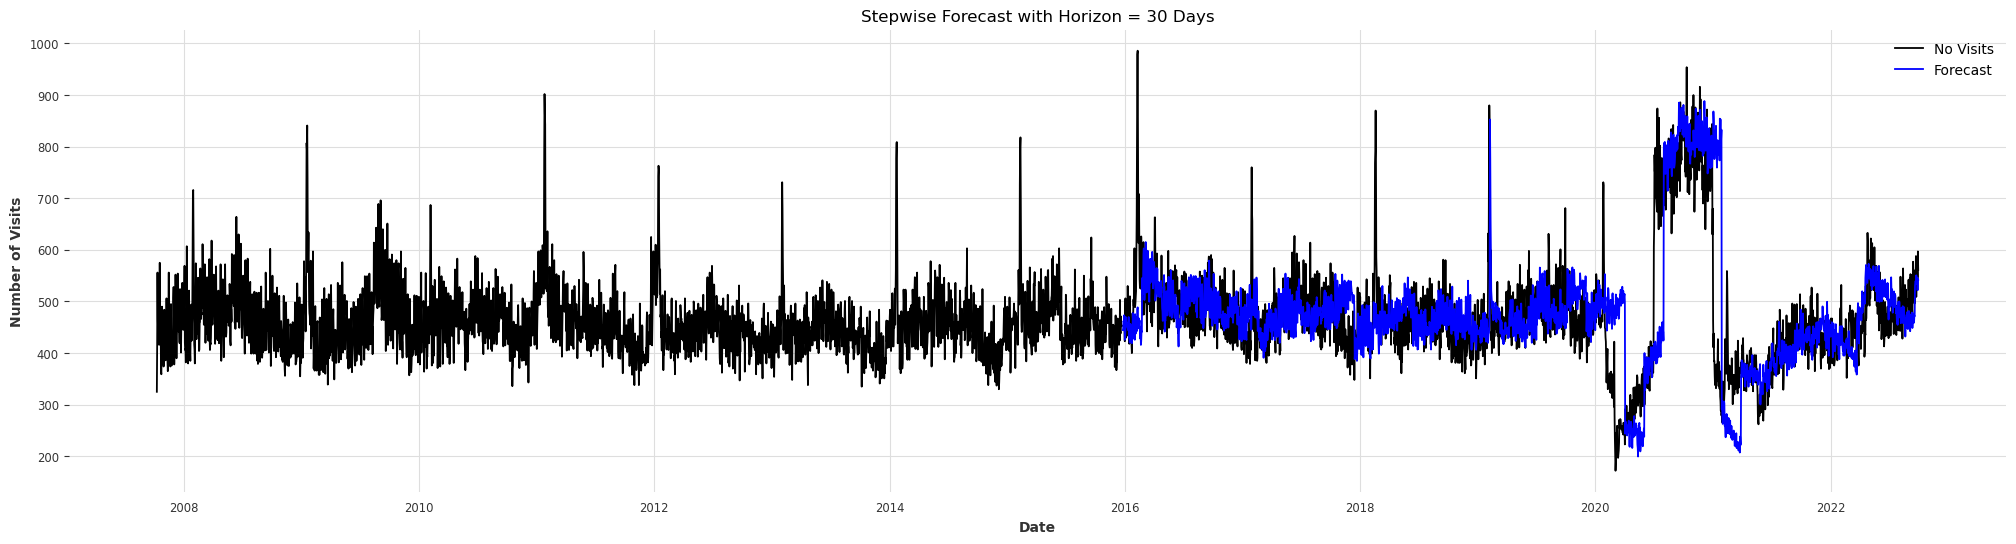

In [148]:
plt.figure(figsize=(25, 6))
#plt.plot(train_df.index, train_df['No'], label='Original Training Data', color='blue')
#plt.plot(test_df.index, test_df['No'], label='Test Set', color='green')
plt.plot(df_combined .index, df_combined, label='No Visits', color='black')
plt.plot(all_forecasts.index, all_forecasts['No'], label='Forecast', color='blue')
plt.xlabel('Date')
plt.ylabel('Number of Visits')
plt.title('Stepwise Forecast with Horizon = 30 Days')
plt.legend()
plt.show()

In [143]:
from darts.metrics import mae, mse, mape
from darts import TimeSeries

MAPE: 13.082609537451484%
MAE: 57.00869802230285


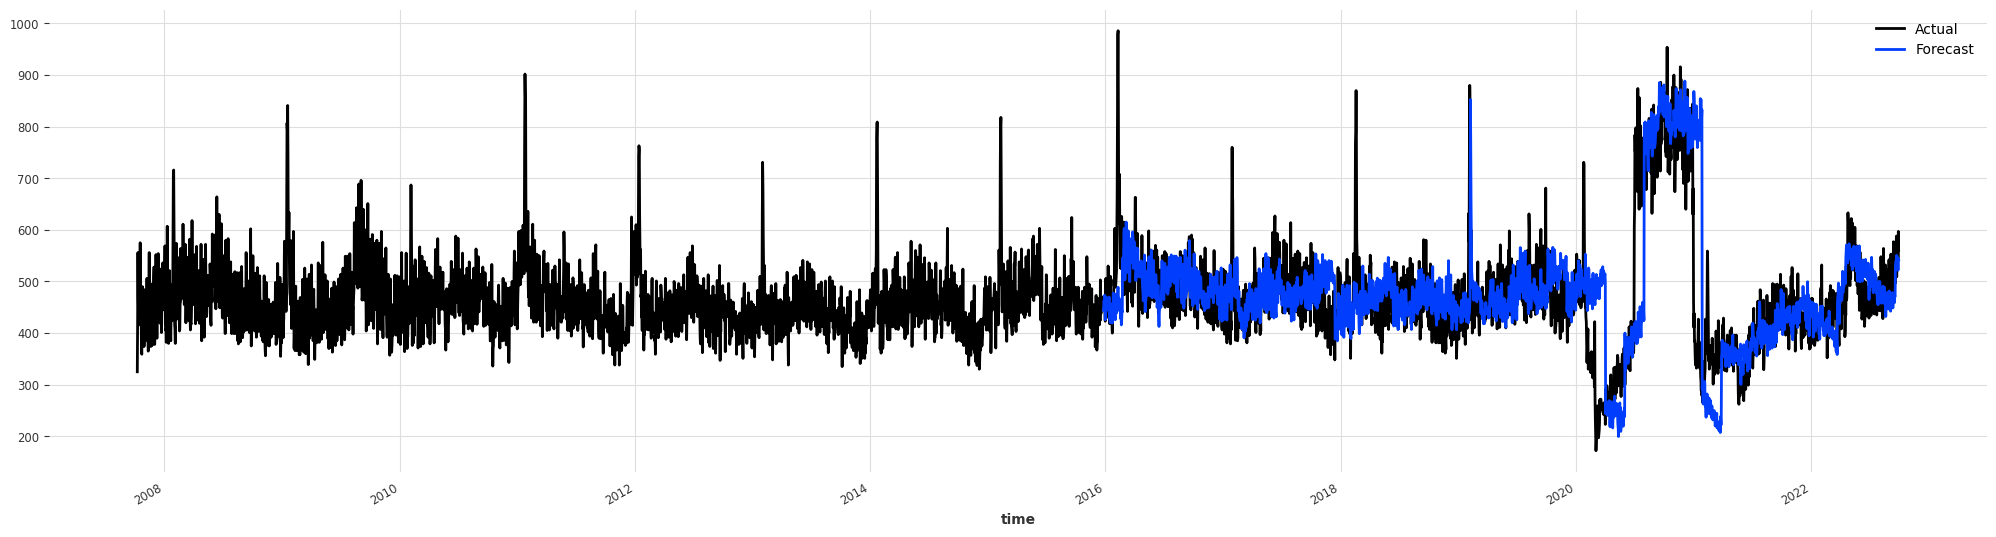

In [149]:
#df_combined = pd.concat([train_df, val_df, test_df])
all_series = TimeSeries.from_dataframe(df_combined, value_cols='No')
Model_prediction_ts_inverse = TimeSeries.from_dataframe(all_forecasts)

#No_array = all_series['No'].values
# Compute MAPE error using the original 'test_series' and the inverse-transformed predictions
MAPE = mape(all_series, Model_prediction_ts_inverse)
MAE = mae(all_series, Model_prediction_ts_inverse)

print(f"MAPE: {MAPE}%")
print(f"MAE: {MAE}")

# Plotting
plt.figure(figsize=(25, 6))
all_series.plot(label="Actual")
Model_prediction_ts_inverse.plot(label="Forecast")
plt.legend()
plt.show()

In [150]:
yearly_dataarrays = {}

for year in range(2017, 2023):  # 从2017到2022
    # 使用TimeSeries的slice方法按年份切片
    # 注意：这里假设时间索引类型是pd.DatetimeIndex
    yearly_series = Model_prediction_ts_inverse.slice(pd.Timestamp(f'{year}-01-01'), pd.Timestamp(f'{year}-12-31'))
    
    # 将每年的TimeSeries转换为DataArray并存储在字典中
    yearly_dataarrays[year] = yearly_series.data_array()

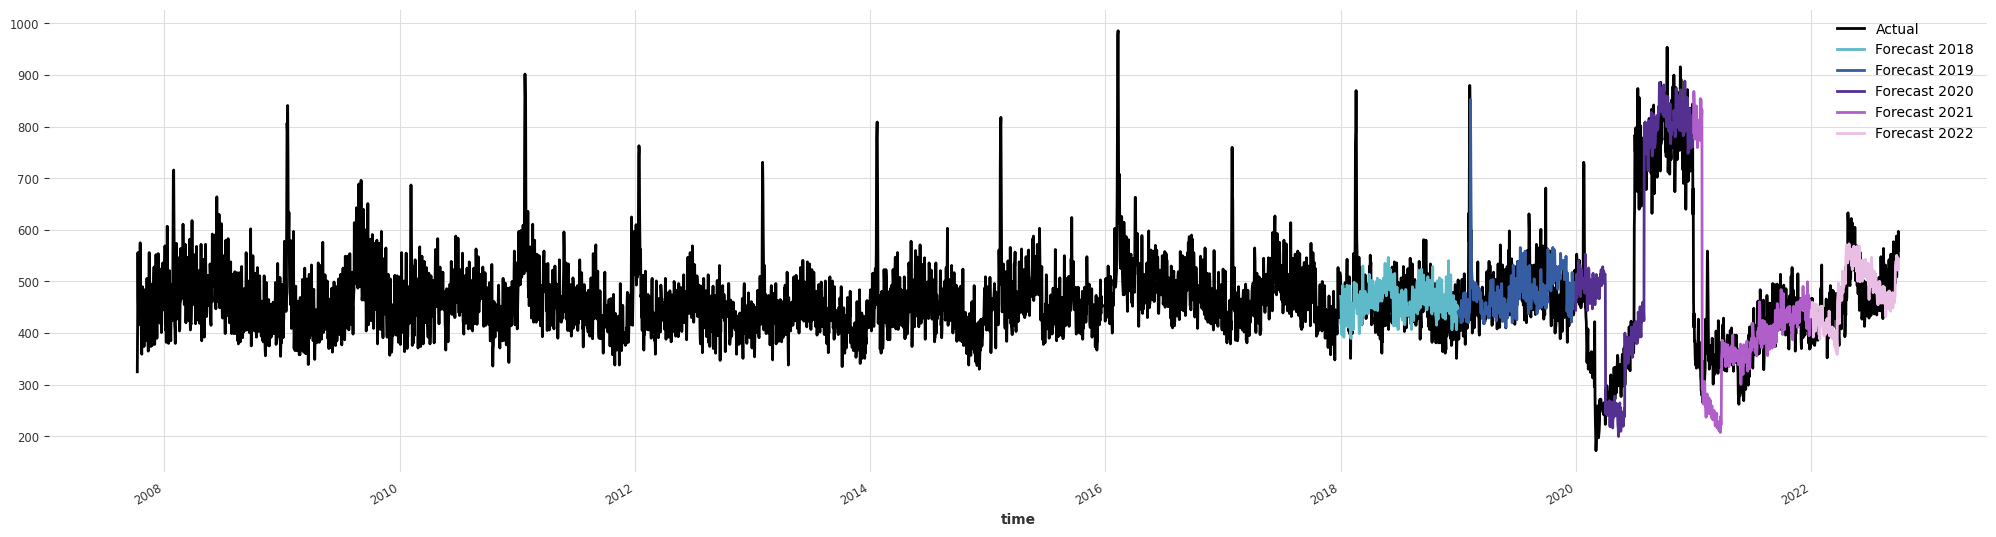

In [151]:
plt.figure(figsize=(25, 6))

# 绘制实际数据
all_series.plot(label="Actual")

# 为2018到2022年的每个年份绘制预测数据
colors = ['#5EB9C9', '#365DA1', '#543091', '#B05EC9', '#E9BEE5']   # 为每个年份指定一个颜色
for i, year in enumerate(range(2018, 2023)):
    # 将DataArray转换回TimeSeries以便使用plot方法
    # 注意：这里假设yearly_dataarrays中存储的是DataArray对象
    ts = TimeSeries.from_xarray(yearly_dataarrays[year])
    
    # 绘制每年的预测数据
    ts.plot(label=f"Forecast {year}", color=colors[i])

# 添加图例
plt.legend()

# 显示图表
plt.show()

In [152]:
metrics = {}

for year in range(2018, 2023):
    # 从all_series中提取相应年份的实际数据
    actual = all_series.slice(pd.Timestamp(f'{year}-01-01'), pd.Timestamp(f'{year}-12-31'))

    # 从yearly_dataarrays中获取预测数据并将其转换为TimeSeries
    forecast = TimeSeries.from_xarray(yearly_dataarrays[year])
    
    # 确保预测数据的时间范围至少与实际数据相交
    # 这里不需要手动对齐，因为mae和mape函数会自动处理
    # 直接计算MAE和MAPE
    metrics[year] = {
        "MAE": mae(actual, forecast),
        "MAPE": mape(actual, forecast)
    }

# 打印结果
for year, m in metrics.items():
    print(f"Year {year}: MAE = {m['MAE']}, MAPE = {m['MAPE']}%")

Year 2018: MAE = 40.148785734829836, MAPE = 8.641379539708357%
Year 2019: MAE = 44.72436130471426, MAPE = 9.093377278853081%
Year 2020: MAE = 98.06284307260982, MAPE = 23.8811165390514%
Year 2021: MAE = 78.52970898771939, MAPE = 21.256651151941895%
Year 2022: MAE = 41.09659461835365, MAPE = 8.731271847887353%
